# Data Reduction Scheme

The goal of this approach is to reduce the amount of data we process by eliminating false positives in given images. Feed in a dataset with or without fibers to properly remove those images that do not contain fibers.

For the training of the Neural network, train with images with and without fibers to introduce variability. 

**Outline**:
- Use Radial Histogram to extract useful statistics from the histogram (mean, meadian, standard dev, etc.)
    - Cluster from these statistics extracted
- Apply supervised or unsupervised methods to get clustering after the application of Radial Hisogram and proper selection of statistic
    - t SNE (yes/no fibers)
    - Hierarchical Clustering
        -Inter vs Intra class 
    - NN MLP (Multilayer Perceptron) 
        - Get confusion matrix from here 

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt #similar to io.imshow(edges), but with more details
from os.path import join

In [4]:
from skimage import color, io, morphology, img_as_ubyte, feature, exposure, filters, util
from skimage.filters import frangi, hessian

In [5]:
ic_fiber = io.ImageCollection("Data/yes_fibers/*.tif", conserve_memory = True)
ic_nofiber = io.ImageCollection("Data/no_fibers/*.tif", conserve_memory = True)

In [6]:
print(np.size(ic_fiber.files),'',np.size(ic_nofiber.files))

29  29


------------------------------------------------------------------------------

### Getting Pictures for poster [ASIDE-IGNORE THIS] NOT PART OF SCHEME


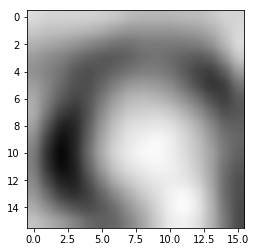

In [8]:
# recall your fibers, lets see the difference between applying a frangi filter, and not.
first_image_fiber = ic_fiber[0]
plt.imshow(first_image_fiber, cmap='gray', interpolation = 'gaussian')

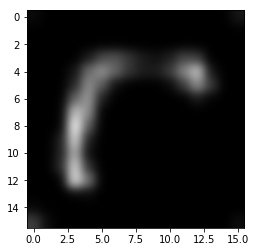

In [9]:
first_image_fiber_filter = frangi(first_image_fiber)
plt.imshow(first_image_fiber_filter, cmap='gray', interpolation= 'gaussian')

**Not super intriguing, so let's put this aside. Maybe other images will be more striking

-----------------------------------------------------------------------------------------

## Radial Profiling
Radial Histograms from center of fiber outwards.

We feed in images containing fibers and no fibers to the function below. 
This returns an array (feature vector) of means or stds of the histograms of each image (obtained from the matrix-the statistic of the radial histogram within the image matrix).

What other statistics can you use?
What is the input for t-SNE?


In [10]:
#Dani's

import numpy as np
import scipy
from scipy import ndimage

# f is your fiber

def radialProfiling(f, stat='mean'):
    nRings = np.min(f.shape) #maximum number of rings allowed 
    wRing = 2 #width of the ring

    nRings = np.rint(np.maximum(nRings/wRing,1))

    sx, sy = f.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    r = np.hypot(X - sx/2, Y - sy/2)
    rbin = (nRings* r/r.max()).astype(np.int)
    if (stat=='mean'):
        radialProfile = ndimage.mean(f, labels=rbin, index=np.arange(1, rbin.max() +1))
    elif(stat=='std'):
        radialProfile = ndimage.standard_deviation(f, labels=rbin, index=np.arange(1, rbin.max() +1))        
    return radialProfile


### Applying to all images

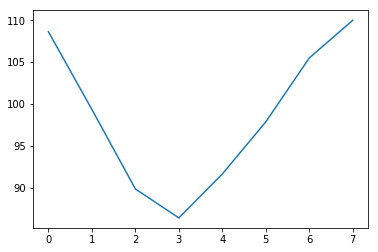

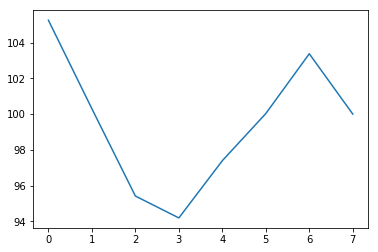

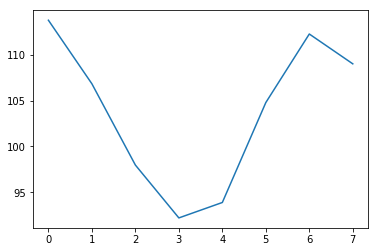

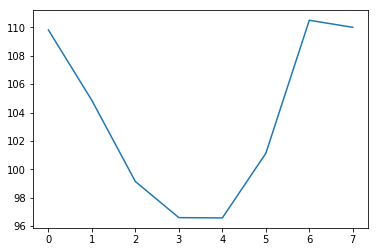

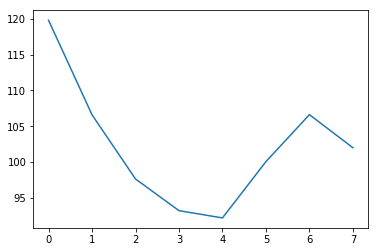

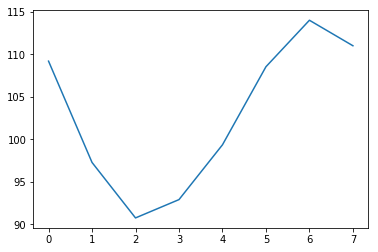

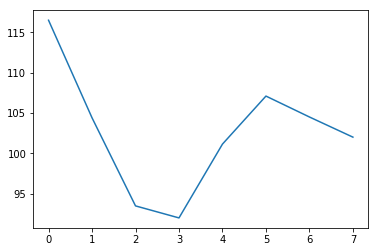

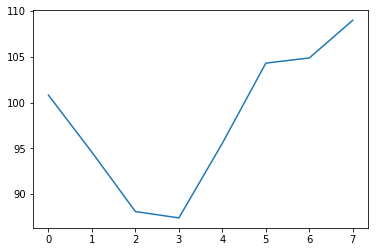

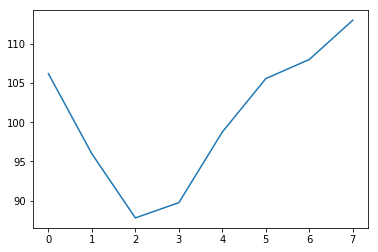

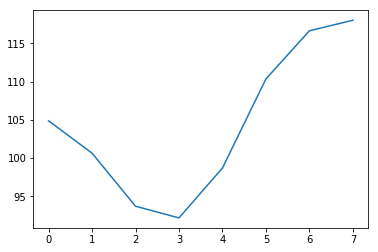

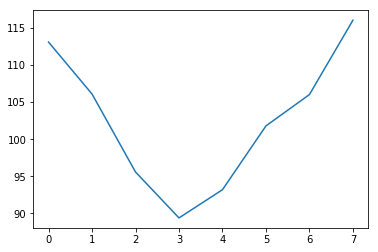

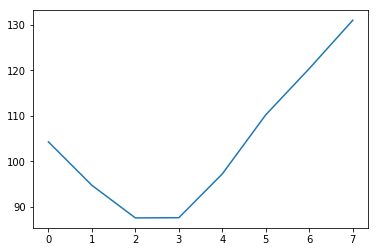

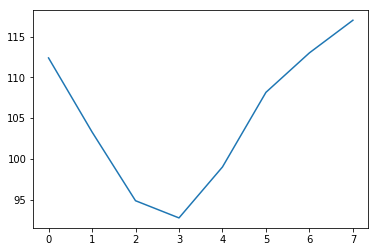

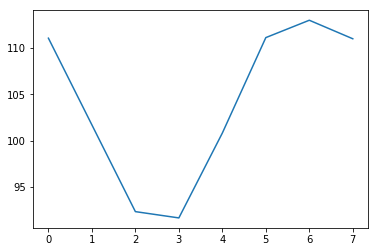

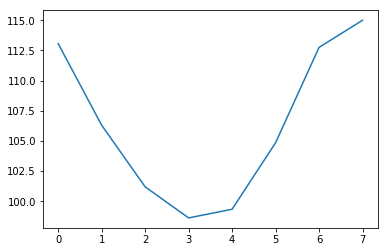

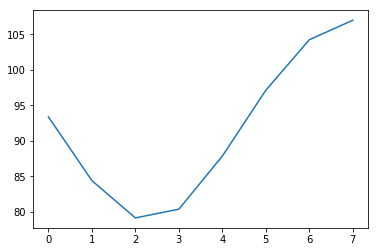

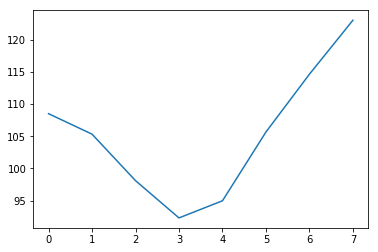

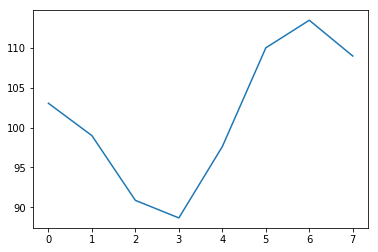

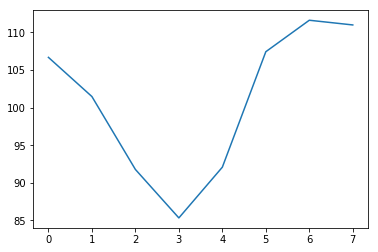

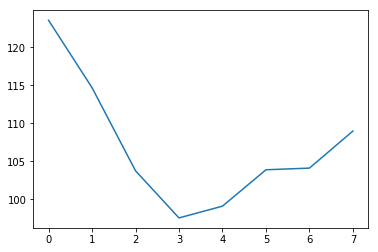

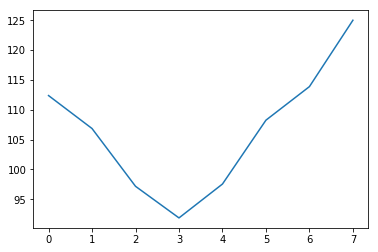

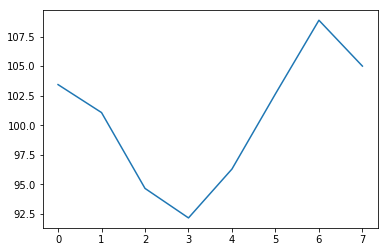

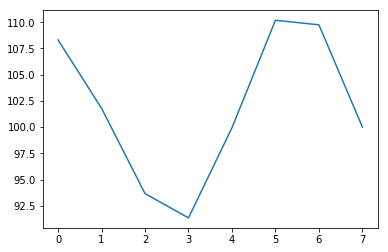

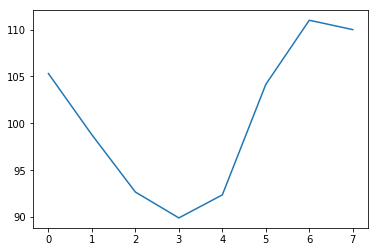

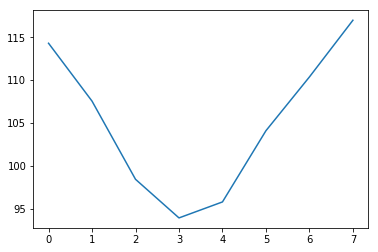

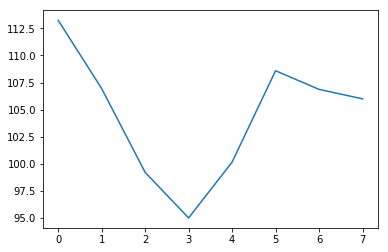

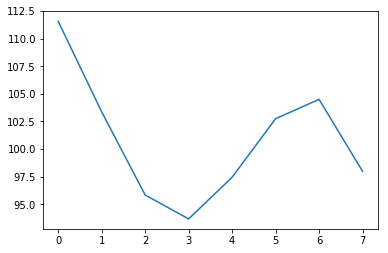

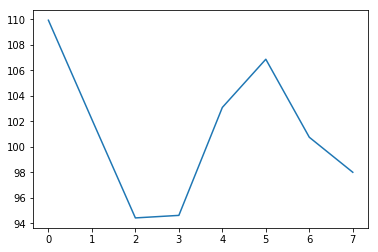

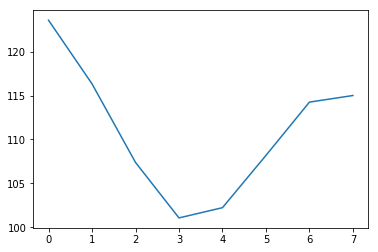

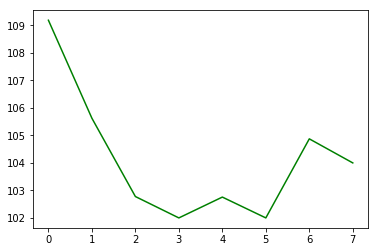

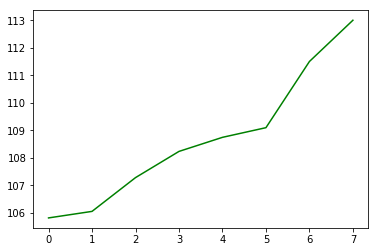

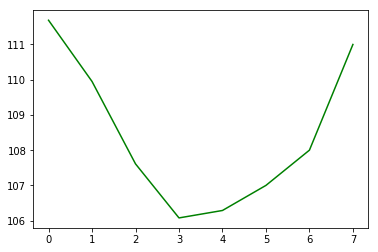

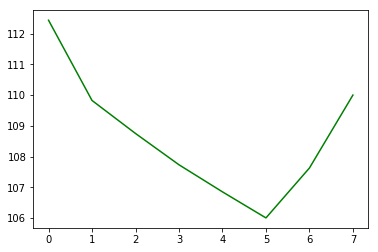

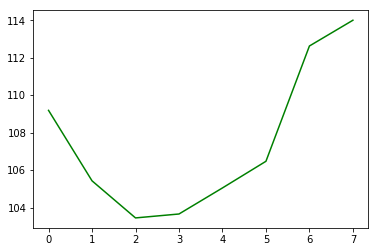

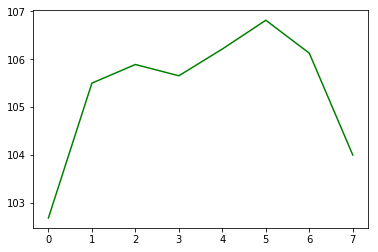

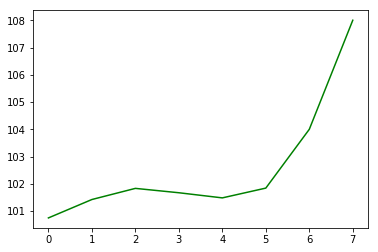

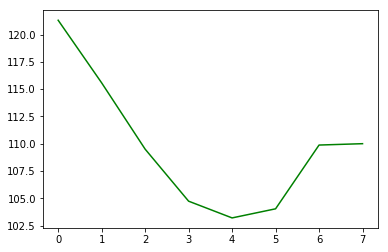

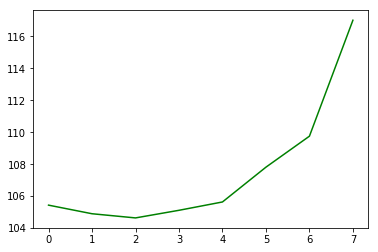

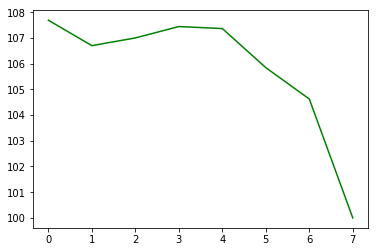

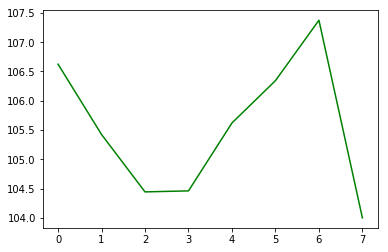

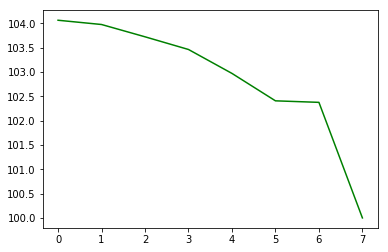

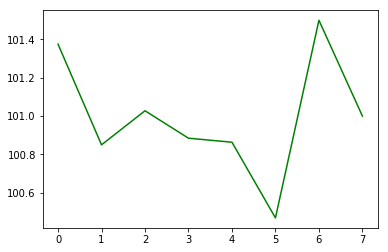

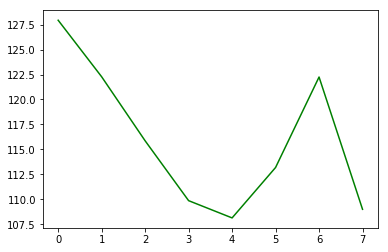

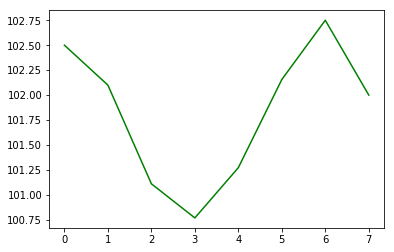

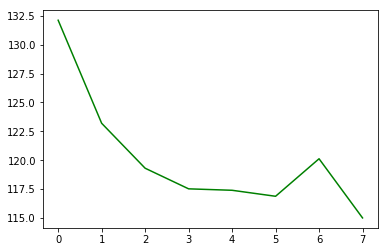

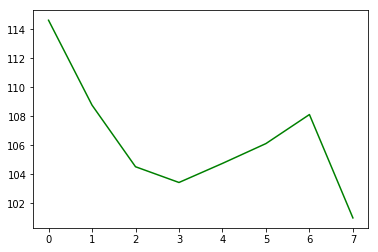

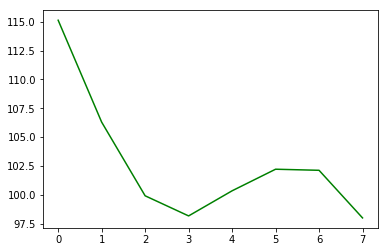

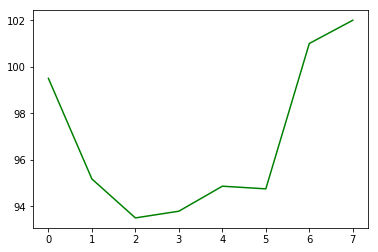

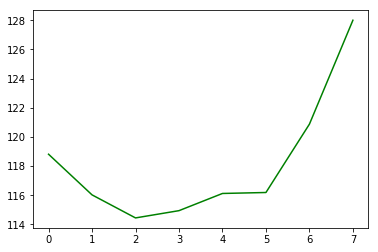

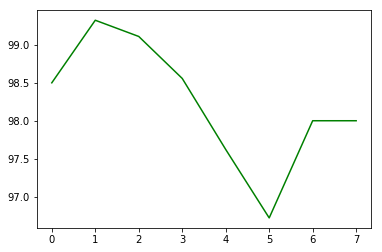

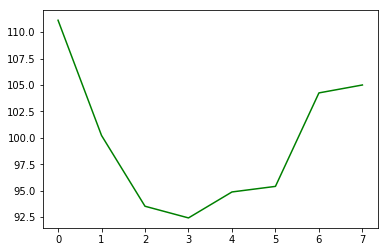

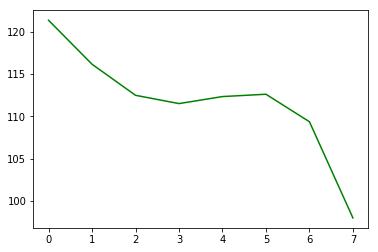

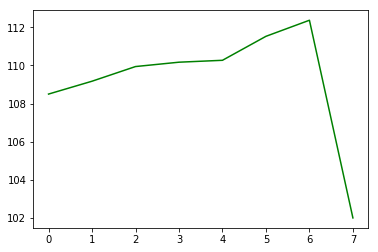

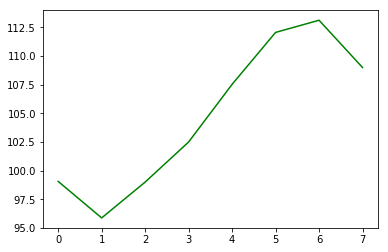

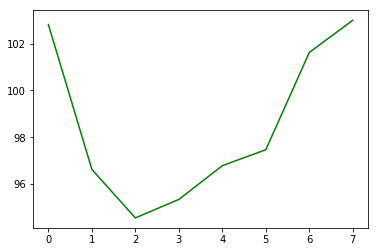

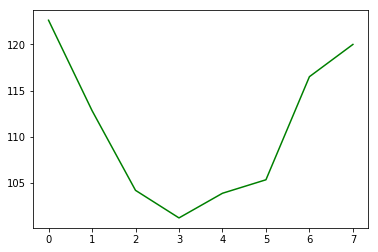

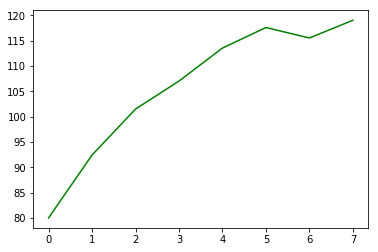

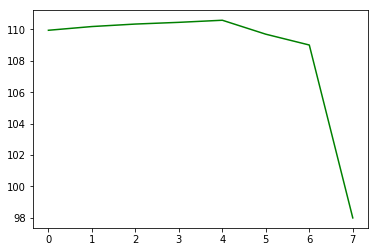

In [12]:
res = []

for p in ic_fiber:
    # extract feature
    #feat_vect =radialProfiling(frangi(p), stat='mean') # apply filter in "p" REMOVING FRANGI
    feat_vect = radialProfiling(p, stat='mean')
    res.append(feat_vect)
    plt.figure()
    plt.plot(feat_vect)

for p in ic_nofiber:
    #feat_vect = radialProfiling(frangi(p), stat='mean') # here too REMOVING FRANGI
    feat_vect = radialProfiling(p, stat='mean')
    res.append(feat_vect)
    plt.figure()
    plt.plot(feat_vect, 'g')
    


## t-SNE Manifold 
Get cluster plot of yes/no 

In [13]:
import sklearn 
from sklearn.manifold import TSNE

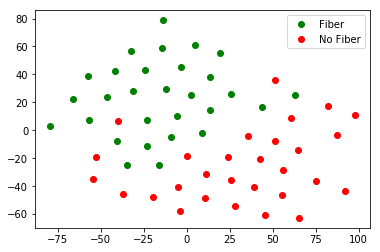

In [17]:
tsne_result = TSNE(n_components=2).fit_transform(res)
plt.plot(tsne_result[:len(ic_fiber),0], tsne_result[:len(ic_fiber),1], 'go', label= "Fiber")
plt.plot(tsne_result[len(ic_fiber):,0], tsne_result[len(ic_fiber):, 1], 'ro', label = "No Fiber")
plt.legend()

#### Conclusion:
The clustering seemed to have worked better using the mean statistic (as there is only two points in the TSNE which lie in the intersection of the two clusters.

There is 29 feature vectors per image of fibers and no_fibers. Each of this image feature vector is stored in "res". All of these are passed into TSNE to cluster based on the feature vectors given. 


## Hierarchical Clustering 

*Intra vs Inter Class*: The objective is to maximize the inter distance between clusters and minimize the intra distance (points within the cluster)

Try both approaches:
1. Agglomerative: (Bottom up) Each point starts in its own cluster and eventually is paired up with other cluster points by following the hierarchy.
2. Divisive: (Top-down) All points start in one cluster, and are divided into more clusters as followed by the hierarchy.

*What is the hierarchy?*

To decide which clusters need to be combined, or where the cluster should be split (For divisive), you will most likeley need to establish a dissimilarity between the sets of observations (use a metric such as euclidean distance, manhattan distance, maximum distance, squared euclidean distance).

Also look into adding a connectivity constraint so that we minimize the overlapping of the clustering (


### Applying all linkage methods and dissimilarities
The best approach seems to be "complete" with an appropriate affinity. So we will see according to its performance wherher or not 50% were detected as fibers/no_fibers (or two distinct clusters in this case). 
We are always going for 2 clusters (since we already know how many clusters we want)

In [18]:
import pandas as pd
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering 
from sklearn.decomposition import PCA

### PCA Projection to 2D
The orginial data has 8 columns (mean of histogram 1, mean of histogram 2,..., mean of histogram 8). We want to project the original data from 8 dimensions to 2 dimensions. Note that after dimensionality reduction, there usually isn't a particular meaning assigned to each principal component. The new components are just the two main dimensions of variation.

In [20]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(res)
pcaDF = pd.DataFrame(data = principalComponents, 
                     columns = ['principal component 1',
                                'principal component 2'])

In [21]:
pcaDF

,principal component 1,principal component 2
0,-18.416195,3.077179
1,-11.429460,-9.337926
2,-3.187672,4.723351
3,-2.924907,1.626059
4,-3.615281,-3.358380
5,-9.251841,7.475742
6,-4.319143,-3.272176
7,-21.411386,1.680291
8,-15.605304,6.529262
9,-7.246863,13.621470


### Now we bind the labels obtained through the Hierarchical Clustering

In [22]:
affinities = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
linkages = ['ward', 'complete', 'average', 'single']

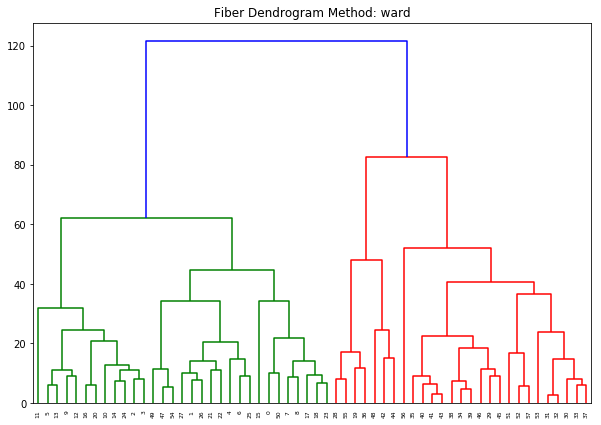

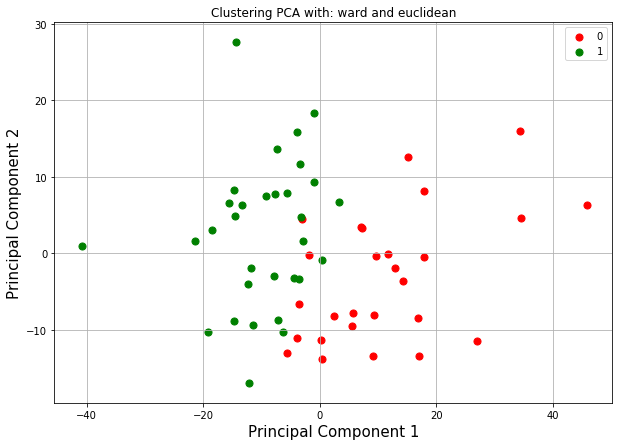

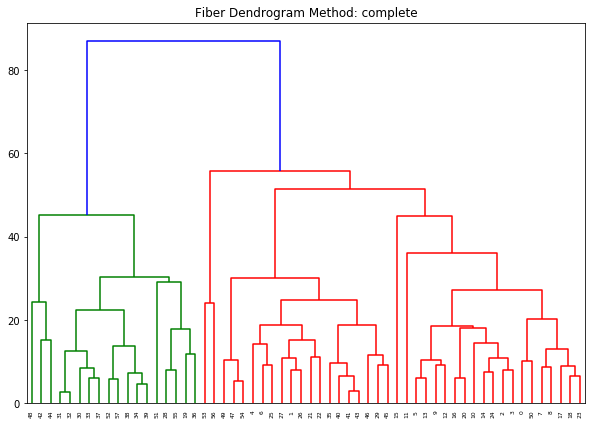

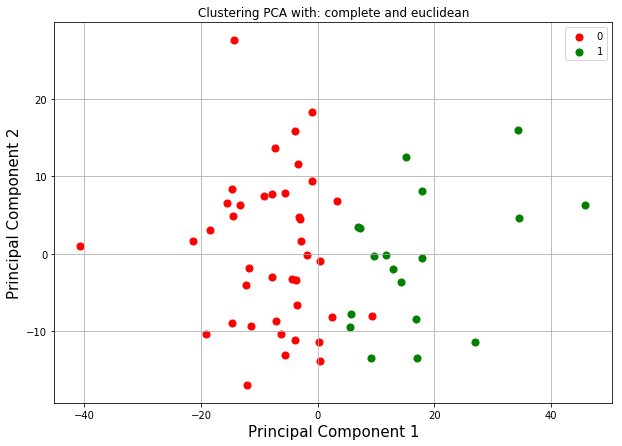

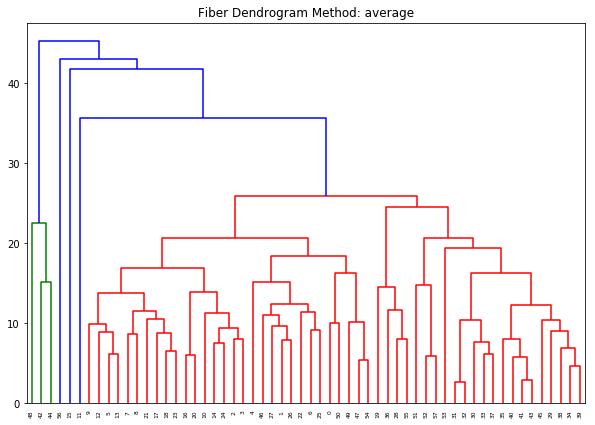

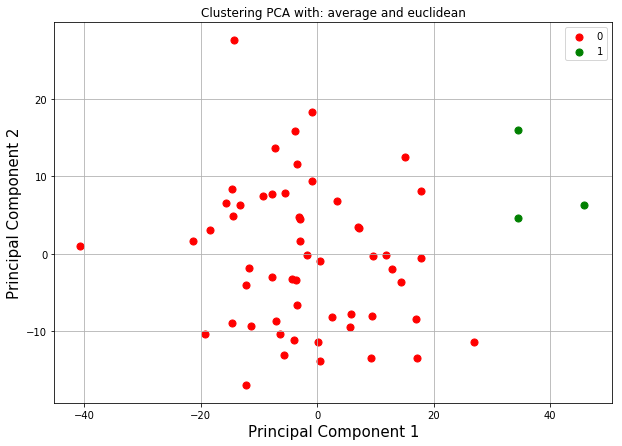

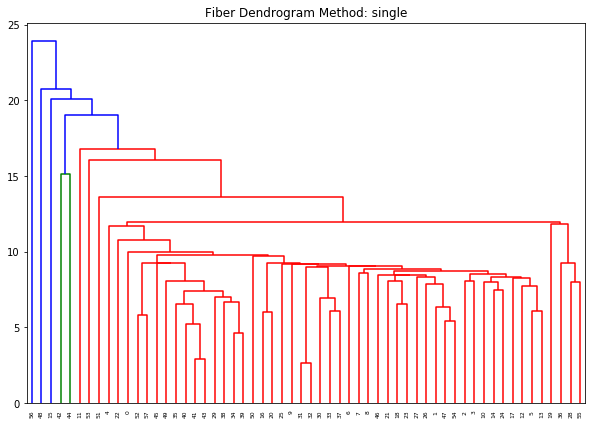

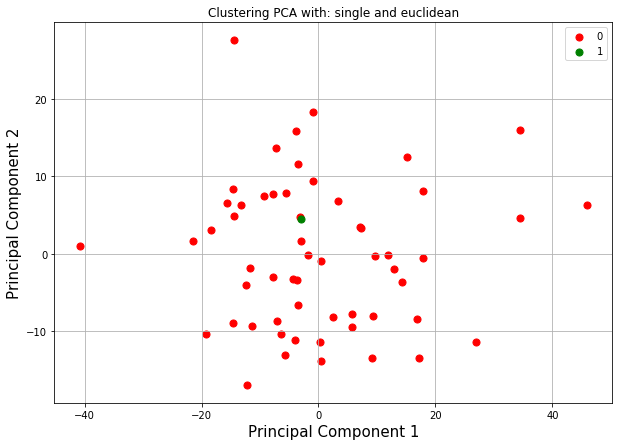

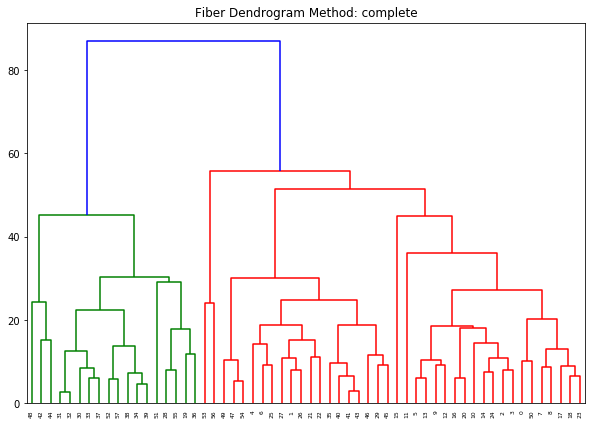

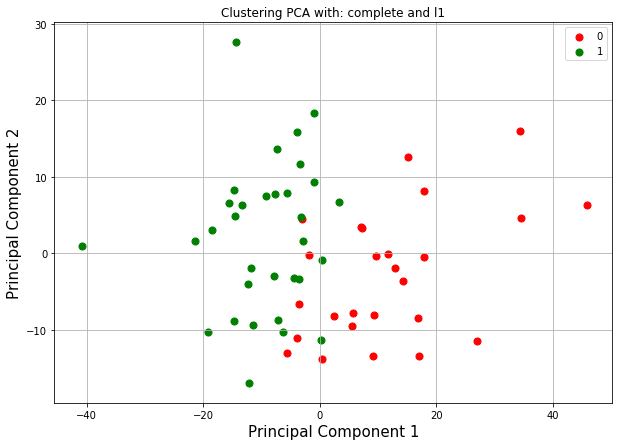

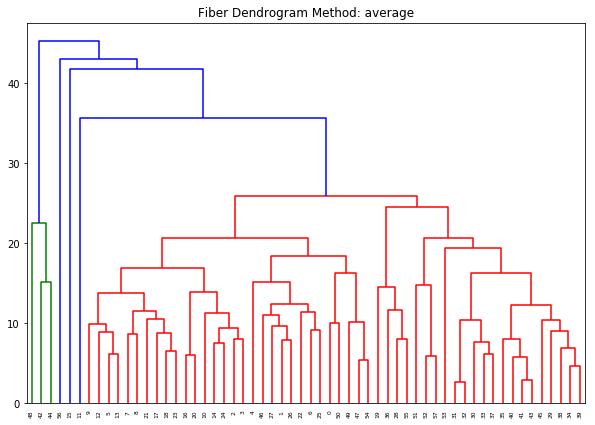

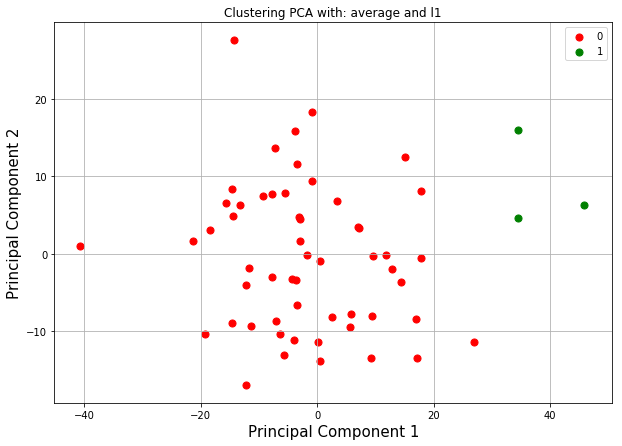

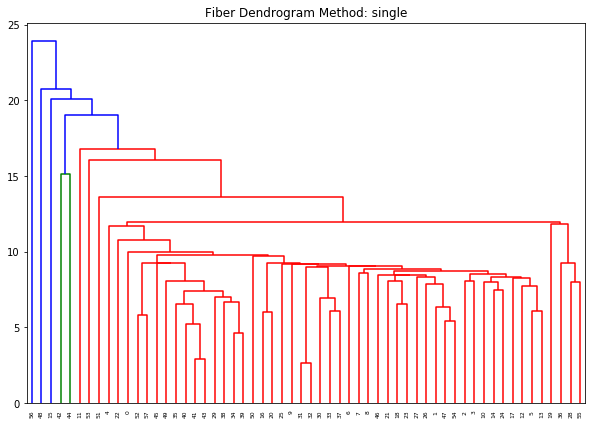

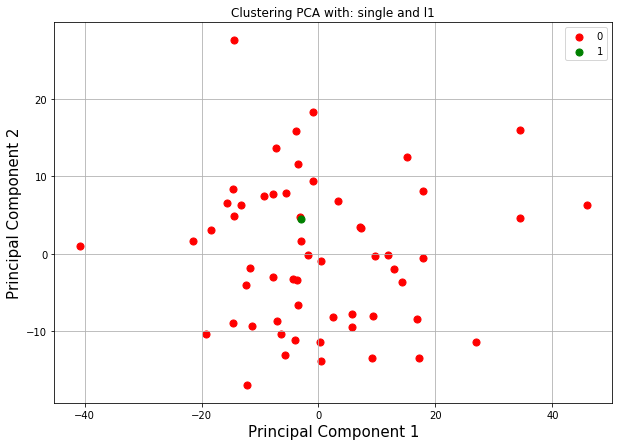

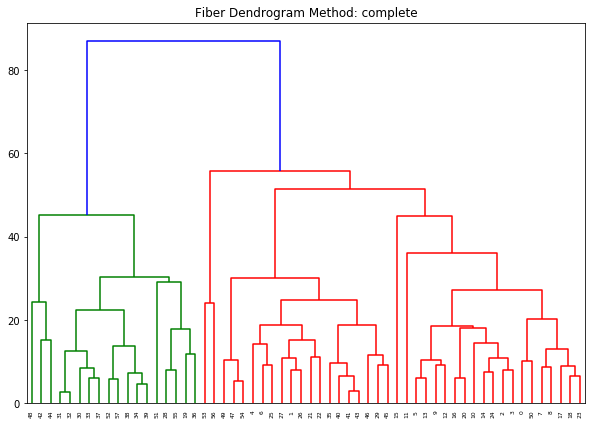

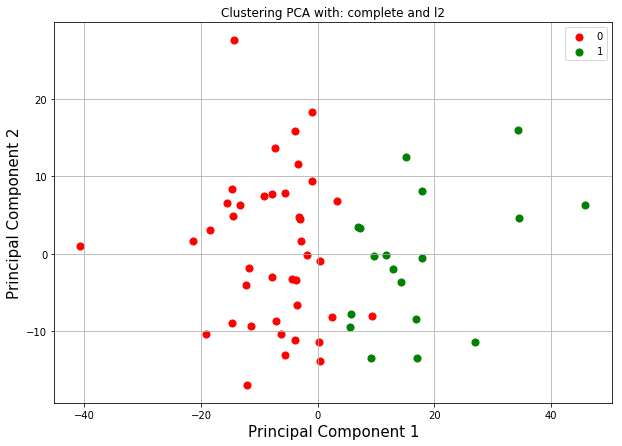

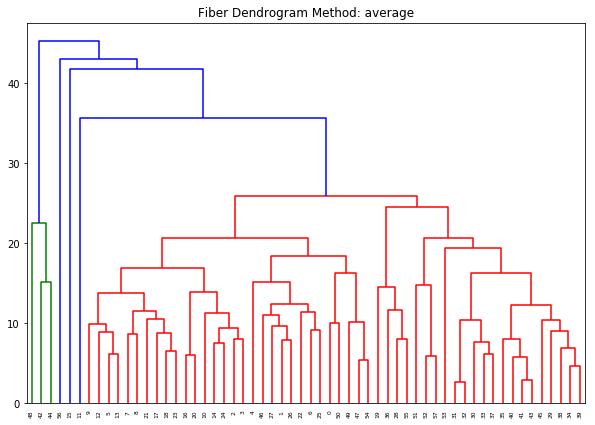

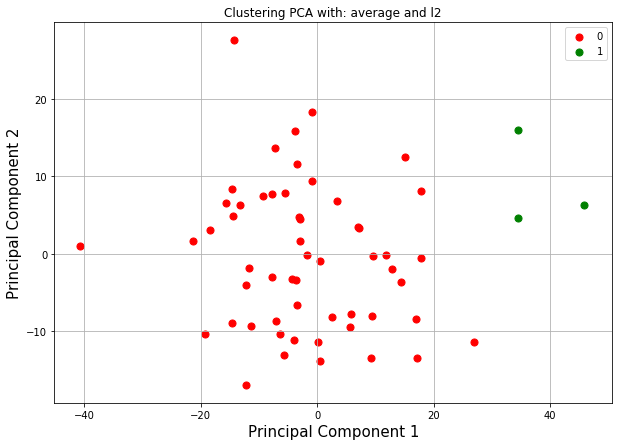

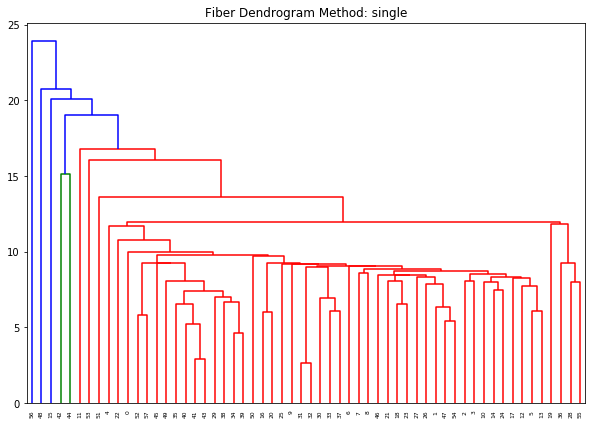

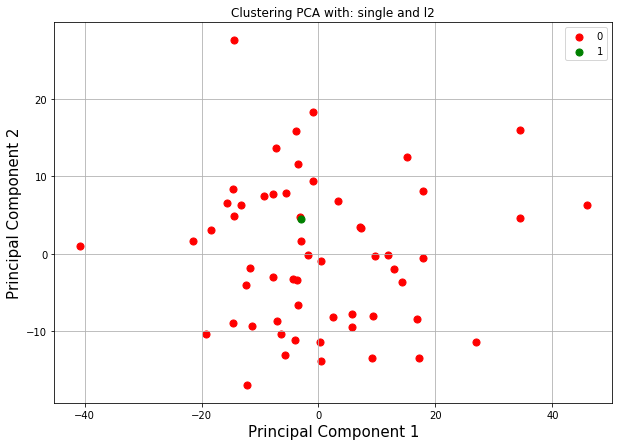

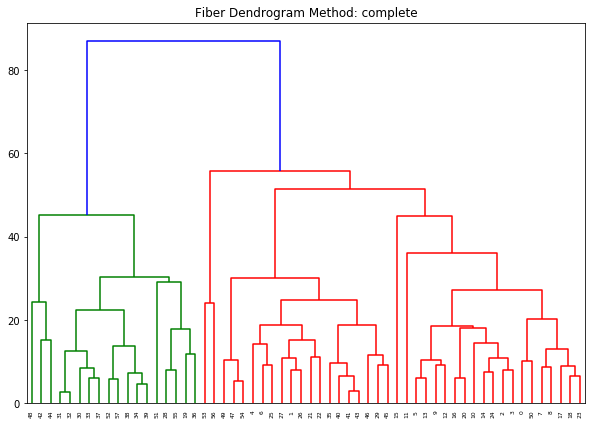

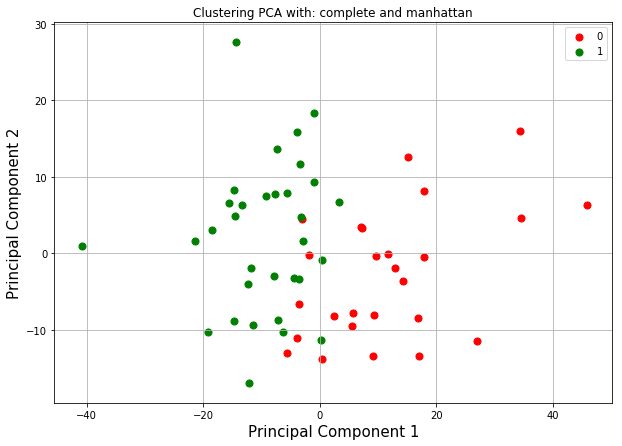

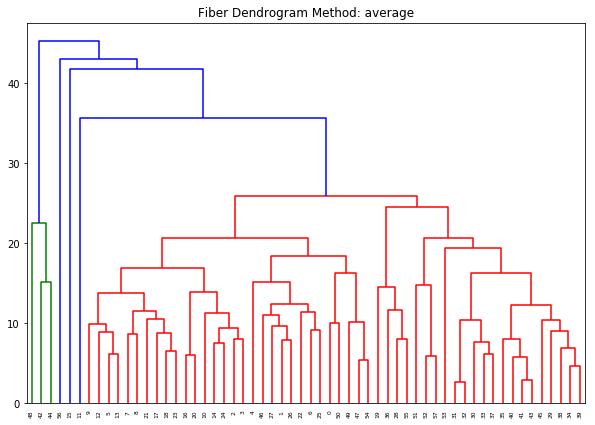

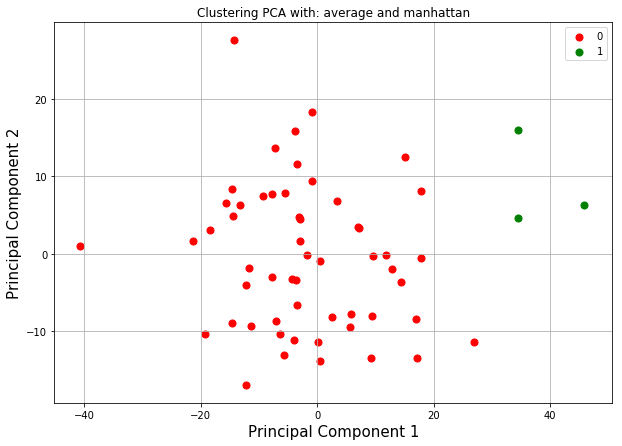

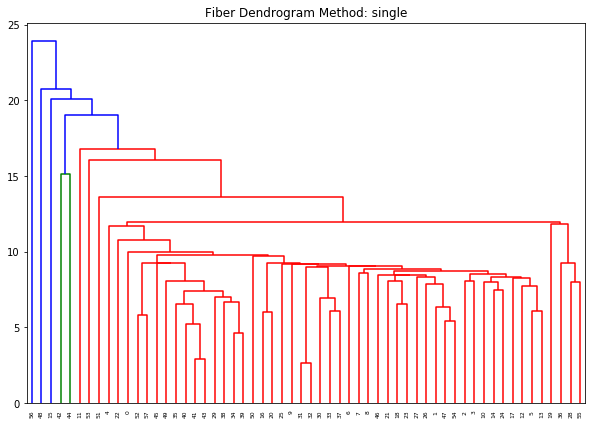

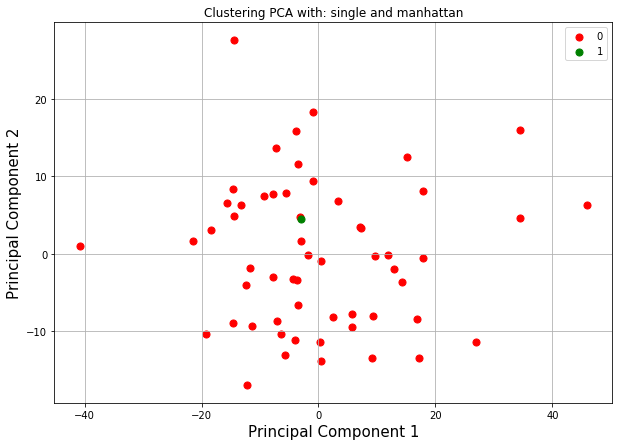

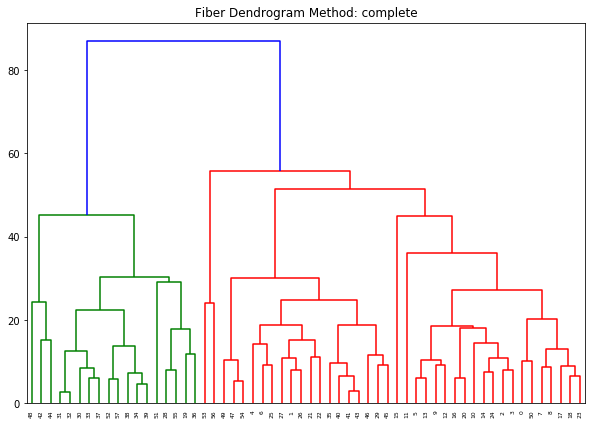

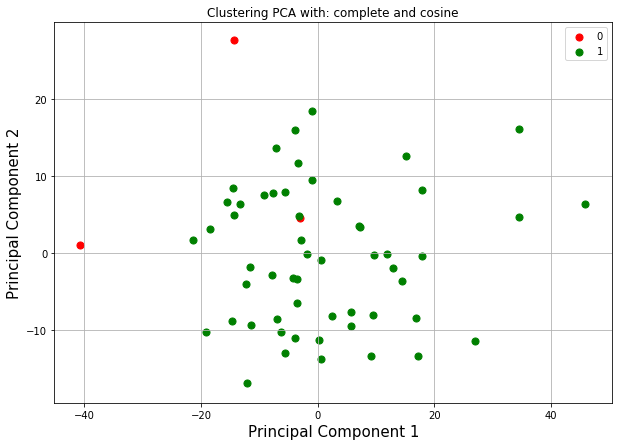

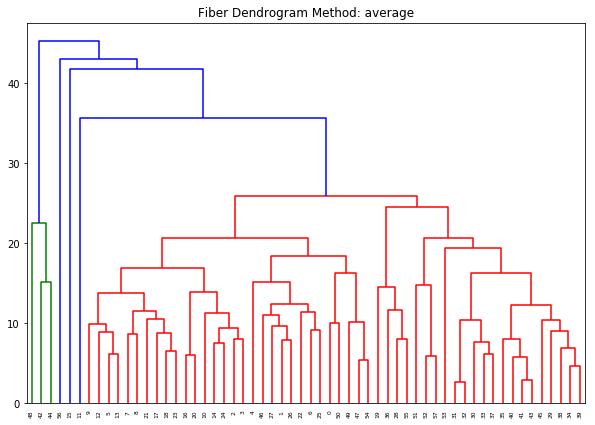

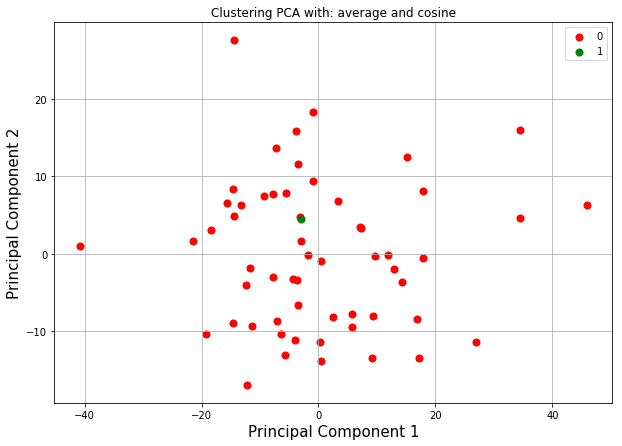

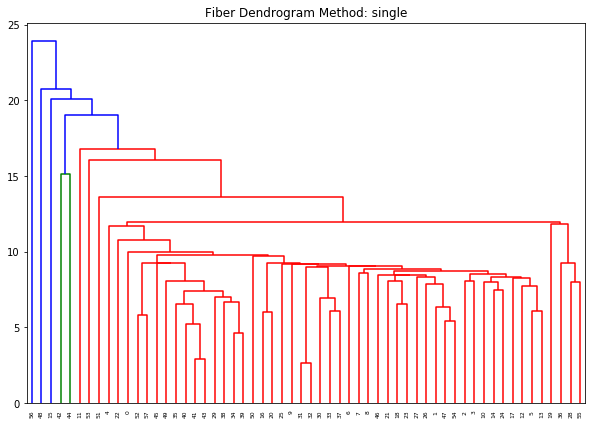

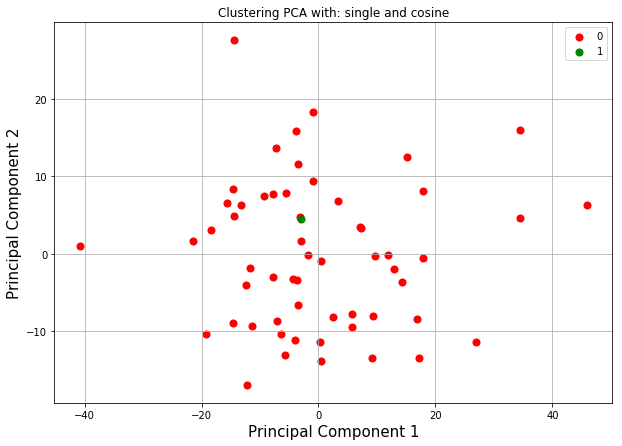

In [32]:
dict_accuracy = {}
for a in affinities:
    scores = []
    
    for link in linkages:
        # 'ward' only works with 'euclidean' distance
        if link == 'ward':
            if a != 'euclidean':
                continue   
                
        # plotting dendrogram: optimize by drawing cross section?
        plt.figure(figsize=(10,7))
        plt.title("Fiber Dendrogram Method: " + link)
        d = shc.dendrogram(shc.linkage(res, method = link), 
                          show_contracted = True) 

        # creating the cluster
        cluster = AgglomerativeClustering(n_clusters = 2, affinity = a, linkage = link)
        cluster.fit_predict(res)
        cluster_labels = cluster.labels_
        
        # cluster accuracy
        acc_percentage = (sum(cluster_labels) / 58) * 100 # invalid for later, we will not know (but as of now...)
        scores.append(acc_percentage)
        
        # label binding to PCA data frame
        pcaDF['Cluster Labels:' + link +' '+ a] = cluster_labels
        
        # visualize 2D projection 
        fig = plt.figure(figsize = (10,7))
        ax = fig.add_subplot(1,1,1)
        ax.set_xlabel('Principal Component 1', fontsize = 15)
        ax.set_ylabel('Principal Component 2', fontsize = 15)
        ax.set_title("Clustering PCA with: " + link + ' and ' + a  )
        
        targets = [0, 1]
        colors = ['r', 'g']
        for target, color in zip(targets,colors):
            indicesToKeep = pcaDF.loc[pcaDF['Cluster Labels:' + link +' '+ a] == target].index
            plt.rcParams.update({'figure.max_open_warning': 0})
            ax.scatter(pcaDF.loc[indicesToKeep, 'principal component 1'],
              pcaDF.loc[indicesToKeep, 'principal component 2'],
              c = color,
              s = 50)    
        ax.legend(targets)
        ax.grid()
    dict_accuracy[a] = scores


In [24]:
for af in affinities:
    if af == 'euclidean':
        continue
    dict_accuracy[af].append(0)
len(dict_accuracy)

5

### Binding actual labels
Comparing the ground truth labels with the obtained clusters, we attach the ground truth at the very end.

In [25]:
first_29 = [1 for i in range(29)]
last_29 = [0 for j in range(29)]
all_fibers = first_29 + last_29
pcaDF['Ground Truth Labels'] = all_fibers
pcaDF

,principal component 1,principal component 2,Cluster Labels:ward euclidean,Cluster Labels:complete euclidean,Cluster Labels:average euclidean,Cluster Labels:single euclidean,Cluster Labels:complete l1,Cluster Labels:average l1,Cluster Labels:single l1,Cluster Labels:complete l2,Cluster Labels:average l2,Cluster Labels:single l2,Cluster Labels:complete manhattan,Cluster Labels:average manhattan,Cluster Labels:single manhattan,Cluster Labels:complete cosine,Cluster Labels:average cosine,Cluster Labels:single cosine,Ground Truth Labels
0,-18.416195,3.077179,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
1,-11.429460,-9.337926,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
2,-3.187672,4.723351,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
3,-2.924907,1.626059,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
4,-3.615281,-3.358380,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
5,-9.251841,7.475742,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
6,-4.319143,-3.272176,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
7,-21.411386,1.680291,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
8,-15.605304,6.529262,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
9,-7.246863,13.621470,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1


### Evaluating Hierarchical Clustering
Comparing outputted labels to ground truth labels

In [26]:
true_labels = pcaDF['Ground Truth Labels']

In [27]:
def perf_measure(y_actual, y_hat): 
    """
    y_actual: ground truth result
    y_hat: our predicted result
    
    """
    TP = 0
    FP = 0 
    TN = 0 
    FN = 0 
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1: 
            TP += 1 
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]: 
            FP += 1 
        if y_actual[i]==y_hat[i]==0: 
            TN += 1 
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]: 
            FN += 1 
    return(TP, FP, TN, FN)

In [28]:
all_measures = {}
for column in pcaDF:
    if column == 'Ground Truth Labels': # skipping ground truth labels
        continue
    all_measures[column] = perf_measure(true_labels, pcaDF[column]) # comparing actual labels with other methods


In [29]:
rec = {}
prec = {}
for col in pcaDF:
    
    # skipping columns that we do not need
    if col == 'Ground Truth Labels':
        continue
    elif col == 'principal component 1':
        continue
    elif col == 'principal component 2': 
        continue
        
    try: re = (all_measures[col][0])/(all_measures[col][0] + all_measures[col][1])
    except ZeroDivisionError: re = 0
    rec[col] = re
    
    try: pr = (all_measures[col][0])/(all_measures[col][0] + all_measures[col][3])
    except ZeroDivisionError: pr = 0
    prec[col] = pr
    

In [30]:
import operator
max(prec.items(), key=operator.itemgetter(1))[0], max(rec.items(), key=operator.itemgetter(1))[0]

('Cluster Labels:ward euclidean', 'Cluster Labels:ward euclidean')

In [31]:
# best values are then:
'Linkage: Ward with Euclidean distance '+ 'precision: ' + str(round(prec['Cluster Labels:ward euclidean'], 3)) + ' recall: ' + str(round(rec['Cluster Labels:ward euclidean'], 3))


'Linkage: Ward with Euclidean distance precision: 0.931 recall: 0.871'

In [82]:
prec

{'Cluster Labels:ward euclidean': 0.9310344827586207,
 'Cluster Labels:complete euclidean': 0.06896551724137931,
 'Cluster Labels:average euclidean': 0.0,
 'Cluster Labels:single euclidean': 0.0,
 'Cluster Labels:complete l1': 0.9310344827586207,
 'Cluster Labels:average l1': 0.0,
 'Cluster Labels:single l1': 0.0,
 'Cluster Labels:complete l2': 0.06896551724137931,
 'Cluster Labels:average l2': 0.0,
 'Cluster Labels:single l2': 0.0,
 'Cluster Labels:complete manhattan': 0.9310344827586207,
 'Cluster Labels:average manhattan': 0.0,
 'Cluster Labels:single manhattan': 0.0,
 'Cluster Labels:complete cosine': 0.9310344827586207,
 'Cluster Labels:average cosine': 0.0,
 'Cluster Labels:single cosine': 0.0}

------------------------------------------------------------------------------------

### On Ward + Euclidean ( the extraction)
Let us replot this to extract information regarding the the clustering of the images, and truly what separates one from the other. 

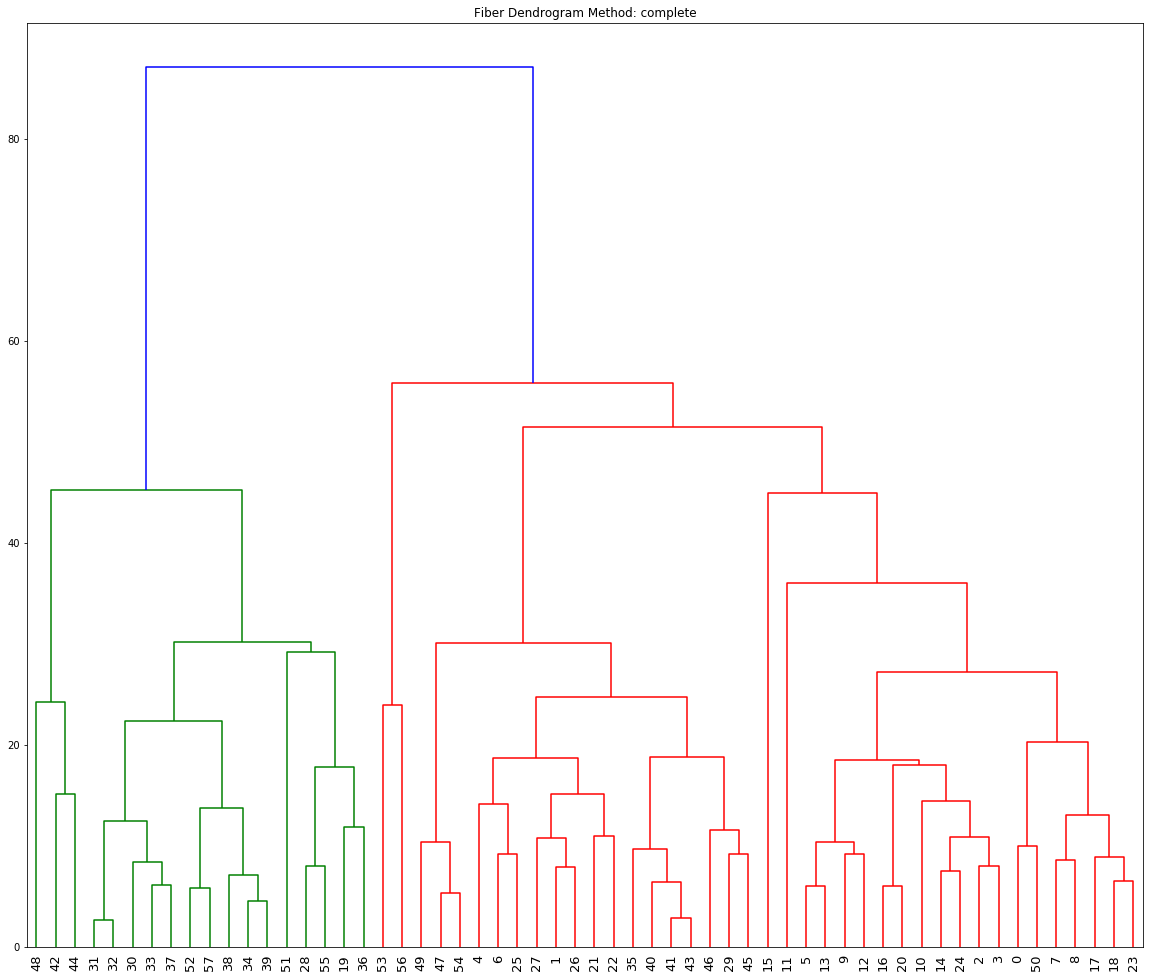

In [97]:
# res is your data, first 29 images are your fibers, second 29 are non fibers [not labeled]
# but since we want to plot the actual clusters, we used PCA (which is fine)
# all we want are the clusters in the dendrogram so we can index into them (in the dictionary)

plt.figure(figsize=(20,17))
plt.title("Fiber Dendrogram Method: " + 'complete')
dendrogram = shc.dendrogram(shc.linkage(res, method = 'complete'),
                           leaf_font_size = 13) 

# creating the cluster
clustering = AgglomerativeClustering(n_clusters = 2, affinity = 'l1', linkage = 'complete')
clustering.fit_predict(res)
clustering_labels = clustering.labels_



In [87]:
# SEPARATION AT 30
 idx['cluster labels'] = clustering_labels

In [88]:
idx

,0,cluster labels
0,48,1
1,42,1
2,44,1
3,31,1
4,32,1
5,30,1
6,33,1
7,37,1
8,52,1
9,57,1


In [ ]:
# plotting images in grid (so that you dont keep doing all these random statements)
import numpy as np
import matplotlib.pyplot as plt

w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

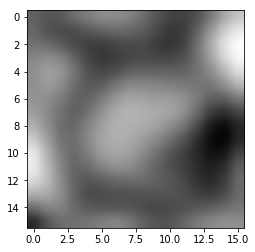

In [96]:
plt.imshow(ic_fiber[27], cmap='gray', interpolation='gaussian')

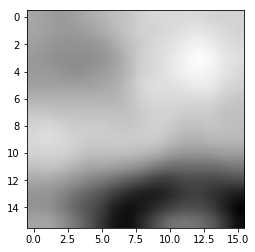

In [95]:
plt.imshow(ic_nofiber[0], cmap='gray', interpolation='gaussian')

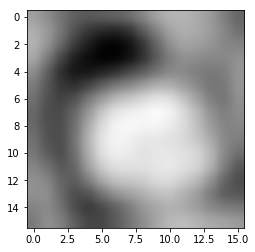

In [92]:
plt.imshow(ic_fiber[19], cmap='gray', interpolation='gaussian')

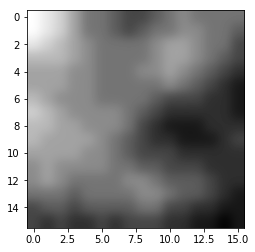

In [89]:
plt.imshow(ic_nofiber[6], cmap='gray', interpolation='gaussian')

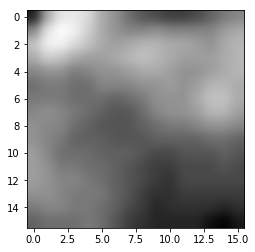

In [90]:
plt.imshow(ic_nofiber[23], cmap='gray', interpolation='gaussian')

### Labels and image comparisson for "ward + euclidean"

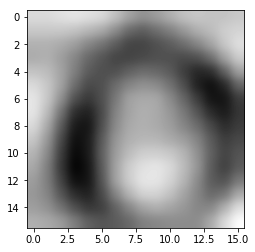

In [66]:
plt.imshow(ic_fiber[7], cmap='gray', interpolation='gaussian')

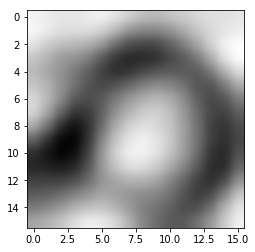

In [54]:
plt.imshow(ic_fiber[8], cmap='gray', interpolation='gaussian')

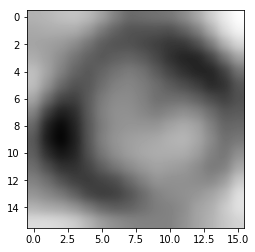

In [55]:
plt.imshow(ic_fiber[17], cmap='gray', interpolation='gaussian')

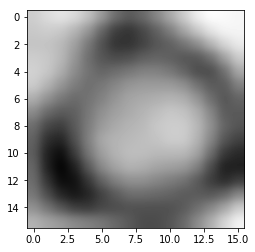

In [56]:
plt.imshow(ic_fiber[18], cmap='gray', interpolation='gaussian')

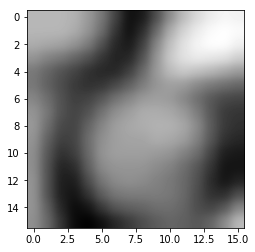

In [57]:
plt.imshow(ic_fiber[23], cmap='gray', interpolation='gaussian')

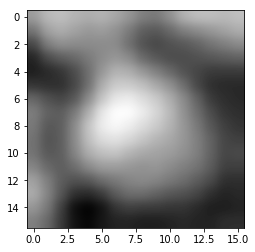

In [58]:
plt.imshow(ic_fiber[28], cmap='gray', interpolation='gaussian')

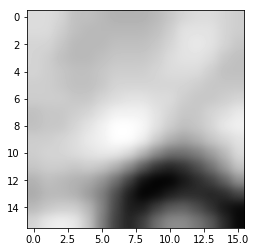

In [68]:
plt.imshow(ic_nofiber[25], cmap='gray', interpolation='gaussian')

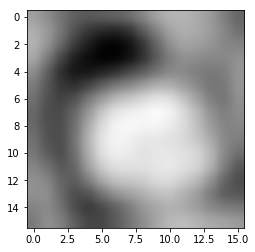

In [62]:
plt.imshow(ic_fiber[19], cmap='gray', interpolation='gaussian')

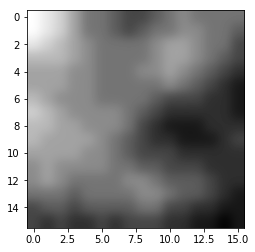

In [63]:
plt.imshow(ic_nofiber[6], cmap='gray', interpolation='gaussian')

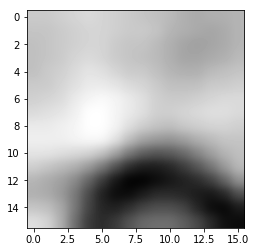

In [65]:
plt.imshow(ic_nofiber[18], cmap='gray', interpolation='gaussian')

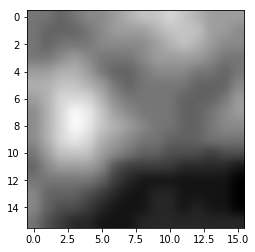

In [69]:
plt.imshow(ic_nofiber[12], cmap='gray', interpolation='gaussian')

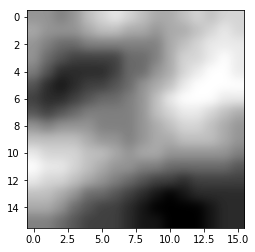

In [70]:
plt.imshow(ic_nofiber[14], cmap='gray', interpolation='gaussian')

## the ones that were labeled as fibers, but weren't.

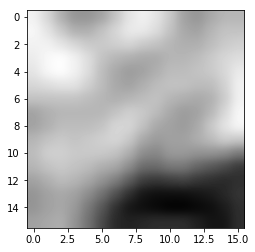

In [71]:
plt.imshow(ic_nofiber[19], cmap='gray', interpolation='gaussian')

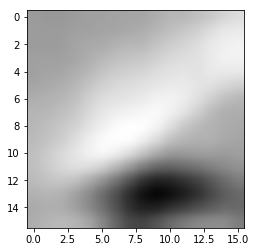

In [73]:
plt.imshow(ic_nofiber[17], cmap='gray', interpolation='gaussian')

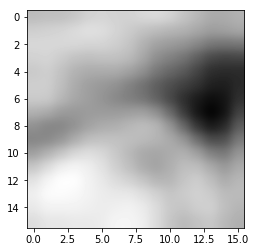

In [74]:
plt.imshow(ic_nofiber[24], cmap='gray', interpolation='gaussian')

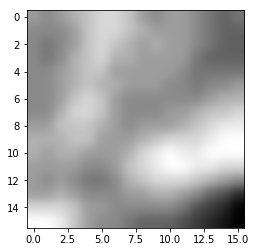

In [75]:
plt.imshow(ic_nofiber[20], cmap='gray', interpolation='gaussian')

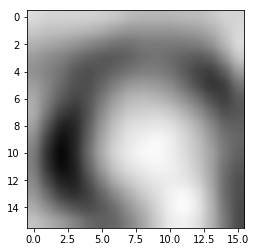

In [76]:
plt.imshow(ic_fiber[0], cmap='gray', interpolation='gaussian')

---------------------------------------------------------------------------------------------------------------------

## Neural Networks
Idea is to flatten all images, and use some of these to train, (these will be used for MLP).
Train to randomize the data according to what is fed (varying from fiber to no fiber)
ex from Dani?
From the multilayer perceptron we will get the confusion matrix.

1. Idea of how many layers?(one hidden layer only, for now)
2. What about transformations of said images? (augmentation, exercise for later)
3. How do these differentiate from the training? 70% and 30% (train, test, respectively)

1. Try MLP first (with either feature vector from radial profiling, then with 16x16 sized vector) no conv nets, neural network first. 
    1. Obtain Confusion matrix from above.
2. Move on to CNNs 
    3. Create a LeNet using Keras (lots of ex's online)
    4. AlexNet afterwards 
    
3. Read book at same time to familiarize (mainly for parameters)

Given that there is no "generate_dataset" function from utils (even after downloading keras). We want to use the MLP to pass in the image as step 1 suggests.
The rough idea of how step one should go is outlined below (in detail).

## Multi Layer Perceptron
The input of this neural network will first be the feature vector of each fiber image (8 components only). After evaluating its performance, we proceed to pass in the actual image of each fiber or no fiber. 
From this step, we proceed to obtain the confusion matrix. 
1. How do we decide the training data from here (of just the input?)
2. Am I ahead of myself a little bit? I think so. One must first load the entire set, decide which data will be trained and which will be tested. From there, we pass in each feat vector or image (one by one) with its own target. And then we pass in the test images/feat vectors to see whether or not these were classified correctly.

The outline
1. Load Data (fibers/no fibers or feature vectors)
2. Define Model
3. Compile Model
4. Fit Model
5. Evaluate Model
6. Tie it all together

    **where do we use the train/test split (use sklearn.model_selection.train_test_split). Figure out the sequential steps again before you try it out**

## Single Multilayer Perceptron Model
We dfine an MLP that learns problem reasonably well. We model it using a softmax activation function on the ouput layer. Meaning that the model will predict a vector with 2 elements with the probability that the sample belongs to each of these 2 classes. Therefore, the first step is to one-hot-encode the class values

In [27]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

Using TensorFlow backend.


In [28]:
data_frame = pd.DataFrame(res)
data_frame['Labels'] = pcaDF['Ground Truth Labels']

We will be working with the "data_frame" dataset.

### Manually selecting Data (Features)

In [30]:
# manually selecting data to train and test

#first_trainXy = data_frame.iloc[0:20,]
#second_trainXy = data_frame.iloc[29:49,]
#first_testXy = data_frame.iloc[20:29,]
#second_testXy = data_frame.iloc[49:59,]
#frames = [first_trainXy, second_trainXy, first_testXy, second_testXy]
#result = pd.concat(frames, ignore_index=True)

### Alternating Classes (Features)

In [61]:
as_array = data_frame.as_matrix()
ones = as_array[:29]
zeros = as_array[29:]

class_alternated = []
for i in range(29):
    class_alternated.append(ones[i])
    class_alternated.append(zeros[i])

/Users/mirasilvia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [95]:
frame_alternated = pd.DataFrame(class_alternated).rename(index=str, columns={8:'Label'})
last_col = frame_alternated['Label'].astype('int')
frame_alternated['Labels'] = last_col
frame_alternated = frame_alternated.drop(['Label'], axis=1)

### Shuffled Classes (Features)

In [183]:
shuffled_frame = data_frame.sample(frac=1).reset_index(drop=True)

### Making simple images to test the neural network
Flatten these, pass them in.

#### Create a lot of these

In [168]:
all_black = []
all_white = []

for i in range(29):
    img_white = np.zeros([16, 16, 3], dtype=np.uint8)
    img_white.fill(255)
    all_white.append(img_white.flatten())
    img_black = np.zeros([16,16, 3], dtype=np.uint8)
    img_black.fill(0)
    all_black.append(img_black.flatten())

In [184]:
white_frame = pd.DataFrame(all_white)
black_frame = pd.DataFrame(all_black)
toget = [white_frame, black_frame]
bw_frame = pd.concat(toget, ignore_index = True)
bw_frame['Labels'] = pcaDF['Ground Truth Labels']

### Flattening Image by Quantization // 32
We quantize each pixel intensity by floor dividing by 32. From there we flatten and proceed to pass into neural network.

In [371]:
# recall your data is ic_fiber and ic_nofiber
# we want to quantize and then flatten all the images
fiber_qf = []
nofiber_qf = []
for i in range(29):
    fib_div = (ic_fiber[i]//32).flatten()
    fiber_qf.append(fib_div)
    nofib_div = (ic_nofiber[i]//32).flatten()
    nofiber_qf.append(nofib_div)    

In [372]:
f = pd.DataFrame(fiber_qf) 
nf = pd.DataFrame(nofiber_qf)
all_fibs = [f,nf]
both = pd.concat(all_fibs, ignore_index = True)
both['Labels'] = pcaDF['Ground Truth Labels']
both_shuffled = both.sample(frac=1).reset_index(drop=True)

### Histogram Equalizer
Apply this function to each image, flatten, and then pass in.

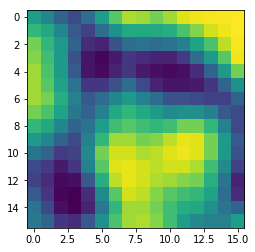

In [453]:
from skimage import exposure
one = ic_fiber[1]
one_eq = exposure.equalize_hist(one)
plt.imshow(one_eq)

In [416]:
fib_eq = []
nofib_eq = []
for i in range(29):
    f_eq = exposure.equalize_hist(ic_fiber[i]).flatten()
    fib_eq.append(f_eq)
    nf_eq = exposure.equalize_hist(ic_nofiber[i]).flatten()
    nofib_eq.append(nf_eq)

In [419]:
eqf = pd.DataFrame(fib_eq)
eqnf = pd.DataFrame(nofib_eq)
all_eq = [eqf, eqnf]
equalized_fibers = pd.concat(all_eq, ignore_index= True)
equalized_fibers['Labels'] = pcaDF['Ground Truth Labels']
equalized_fibers_shu = equalized_fibers.sample(frac=1).reset_index(drop=True)

### Quantization and Equalization (both)
Applying both to image prior to flattening. Then pass in to NN.

In [427]:
fib_std = []
nofib_std = []
for i in range(29):
    fibs = exposure.equalize_hist(ic_fiber[i]//32).flatten()
    fib_std.append(fibs)
    nofibs = exposure.equalize_hist(ic_nofiber[i]//32).flatten()
    nofib_std.append(nofibs)

In [439]:
fdf = pd.DataFrame(fib_std)
nfdf = pd.DataFrame(nofib_std)
blend = [fdf, nfdf]
standarized_df = pd.concat(blend, ignore_index=True)
standarized_df['Labels'] = pcaDF['Ground Truth Labels']
std_fibs_shuffled = standarized_df.sample(frac=1).reset_index(drop=True)

### Flattening Images only
Instead of Standarizing the images throgh quantization or histogram equalization we flatten these and feed into NN.

In [440]:
flat_fib = []
flat_nofib = []
for j in range(29):
    ff = ic_fiber[j].flatten()
    flat_fib.append(ff)
    nff = ic_nofiber[j].flatten()
    flat_nofib.append(nff)

In [443]:
frame_1 = pd.DataFrame(flat_fib)
frame_2 = pd.DataFrame(flat_nofib)
frames = [frame_1, frame_2]
all_flat = pd.concat(frames, ignore_index=True)
all_flat['Labels'] = pcaDF['Ground Truth Labels']
flat_shuffled = all_flat.sample(frac=1).reset_index(drop=True)

### Loading Data

In [444]:
# loading feat vectors first (8 features)
# question still remains: is it the network? is it the fact that i am passing
# the feature vectors? what if instead i pass in a flattened image?


# shuffled classes
#X = shuffled_frame.as_matrix(columns=shuffled_frame.columns[:8]) # to evaluate/train/test
#y = shuffled_frame['Labels'] # actual labels 

# double check
#X = result.as_matrix(columns=result.columns[:8]) # to eavluate/train/test
#y = result['Labels'] # labels

# alternating classes
#X = frame_alternated.as_matrix(columns=frame_alternated.columns[:8])
#y = frame_alternated['Labels']

# simple black and white images to test the networks (we should get 100%)
#X = bw_shuffled.as_matrix(columns=bw_shuffled.columns[:768])
#y = bw_shuffled['Labels']

# quantized and flattened images to pass into MLP df: 'both_shuffled'
#X = both_shuffled.as_matrix(columns=both_shuffled.columns[:256])
#y = both_shuffled['Labels']

# equalized and flattened images to pass into MLF df: "equalized_fibers_shu"
#X = equalized_fibers_shu.as_matrix(columns=equalized_fibers_shu.columns[:256])
#y = equalized_fibers_shu['Labels']

# completeley standarized images (quantized and equalized) df: std_fibs_shuffled
#X = std_fibs_shuffled.as_matrix(columns=std_fibs_shuffled.columns[:256])
#y = std_fibs_shuffled['Labels']

# only the images flattened without any standarization df: "flat_shuffled"
X = flat_shuffled.as_matrix(columns=flat_shuffled.columns[:256])
y = flat_shuffled['Labels']

/Users/mirasilvia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [445]:
# one hot encoding
from keras.utils import to_categorical
y = to_categorical(y)

### Data Splitting
Split data into training and test sets. We use the test set to both evaluate the performance of the model and to plot its performance during training with a learning curve. We will use 70% of the data for training and 30% for the test set. 



In [446]:
# split into train and test - doing 40 right now because of how we chose to train the data
n_train = int(0.9 * X.shape[0]) # 70% of 58 images ~ 40 images
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

### Defining Model
Now we define and combine the model. The model expects samples with 8 input variables. The model has a single hidden layer with 6 nodes and a rectified linear activation function, then an output layer with 2 nodes to predict the probability of each of the 2 classes, and a softmax activation function.

In [447]:
# define model
model = Sequential()
model.add(Dense(100, input_dim=256, activation='relu'))
#model.add(Dense(70, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Fitting Model
The model is fit for 6 training epochs and we will evaluate the model each epoch on the test set, using the test set as a validation set. 

In [448]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=6, verbose=0)

### Evaluating the Model
At the end of the fitting step, we evaluate the performance of the model on both the train and the test sets.

In [449]:
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' %(train_acc, test_acc))

Train: 0.481, Test: 0.667


## How can you optimize the current model?
Well, given that the features still give us zero improvement in the neural network. We proceed to equalize and quantize the intensities of the images before flattening them and then passing them into the neural network. 

Recall that Dani first suggested that you do the quantization through skimage or learn (see notes). But it goes as follows:
1. You have 2^8 intensities in the images from your image collection.
2. You want to reduce this to 2^3, by (int) dividing each intensity by 32. 
3. This will reduce all to quantize all the intensities and therefore reduce the data. 
4. From here you can flatten the image and then feed it into the MLP.

**Results: Definite improvement with the quantization and change of data. To optimize: increase data, split, early stop or perhaps increase # of epochs. Add a layer?**

The other goes as follows (Histogram equalizer)
1. Might have to look this method up a bit (you are equalizing the histogram of each image). 
2. Then you flatten the image
3. Pass into the MLP

**Results: test 100% train 96% with current metrics, one run only**

Last method could be to try both? 
1. Quantize and then Histogram equalizer: VERY POOR RESULTS
2. Flatten image: POOR RESULTS TOO
3. Feed into MLP, feed what though?

Questions arising:
1. What was the normalization method?